## Introduction
**This challenge is the capstone project of the Summer Analytics, a primer course on Data Science, conducted by Consulting and Analytics Club of IIT Guwahati in the summers.**

**The dataset is provided by DeltaX is the pioneering cross-channel digital advertising platform. The cloud-based platform leverages big data, user behavior, and machine learning algorithms to improve performance across the business funnel of advertisers.**

## Data Description

date: the date on which the ad was made live

campaign: campaign number

adgroup: adgroup number

ad: ad number

impressions - Number of time the ad was shown

clicks - Number of time the ad clicked shown

cost - Amount spent to show ad

conversions - Number of transactions received

revenue: revenue generated from the ad

## Importing modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10
plt.warnings.filterwarnings('ignore')

## Reading and exploring dataset

In [3]:
train_df=pd.read_csv('Train_Data.csv')
test_df=pd.read_csv('Test_Data.csv')

In [4]:
train_df.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [5]:
test_df.head()

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.58,121,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.17,22,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.05,5,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.01,2,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.01,3,1,0


In [6]:
train_df.shape,test_df.shape

((4571, 9), (318, 8))

In [7]:
# Adding test and traing flag so that we can split train/test data
train_df['tst']=0
test_df['tst']=1

In [8]:
# concatenating train and test data for data preprocessing
data=pd.concat([train_df,test_df],axis=0,copy=True)
data.head()
df=data.copy()

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
clicks,4889.0,42.454899,97.591346,0.0,2.00,7.00,38.00,1771.00
conversions,4889.0,1.304357,5.073662,0.0,0.00,0.00,1.00,94.00
cost,4889.0,2.643461,13.900229,0.0,0.04,0.19,1.26,531.25
impressions,4889.0,90.977705,193.610988,1.0,5.00,16.00,85.00,3239.00
revenue,4571.0,231.865340,1091.742763,0.0,0.00,0.00,92.60,20515.41
tst,4889.0,0.065044,0.246629,0.0,0.00,0.00,0.00,1.00


In [10]:
df.isna().sum()

ad               0
adgroup          0
campaign         0
clicks           0
conversions      0
cost             0
date             0
impressions      0
revenue        318
tst              0
dtype: int64

In [11]:
df[(df.conversions==0) & (df.tst==0)].shape

(3213, 10)

In [12]:
df[(df.cost==0) ].shape

(480, 10)

## Feature Engineering

In [13]:
data['day']=data['date'].apply(lambda x:x[0:2]).astype(int)

data['month']=data['date'].apply(lambda x:x[3:5]).astype(int)

data['year']=pd.DatetimeIndex(data['date']).year

In [14]:
data.shape
df=data.copy()

In [15]:

df['date'] = pd.to_datetime(df.date,format='%d-%m-%Y')
df.index = df['date']


In [16]:
date_ind=df.index
date_ind

DatetimeIndex(['2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
               '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
               '2020-08-01', '2020-08-01',
               ...
               '2021-03-15', '2021-03-15', '2021-03-15', '2021-03-15',
               '2021-03-15', '2021-03-15', '2021-03-15', '2021-03-15',
               '2021-03-15', '2021-03-15'],
              dtype='datetime64[ns]', name='date', length=4889, freq=None)

In [17]:
df['CPC']=df.cost.divide(df.clicks).replace(np.inf,0).replace(np.nan,0)
df['CTR']=df.clicks.divide(df.impressions).replace(np.inf,0).replace(np.nan,0)
df['COA']=df.cost.divide(df.conversions).replace(np.inf,0).replace(np.nan,0)


In [18]:
# don't run this
# df.drop(columns=['date'],axis=1,inplace=True)

# df['ROI']=df[df.tst==0].revenue.divide(df[df.tst==0].cost).replace(np.inf,0).replace(np.nan,0)

In [19]:
df['ad']=df['ad'].str.slice(3).astype(int)

df['adgroup']=df['adgroup'].str.slice(8).astype(int)

df['campaign']=df['campaign'].str.slice(-1).astype(int)

df.head()

,ad,adgroup,campaign,clicks,conversions,cost,date,impressions,revenue,tst,day,month,year,CPC,CTR,COA
date,,,,,,,,,,,,,,,,
2020-08-01,1,1,1,6,0,0.08,2020-08-01,24,0.00,0,1,8,2020,0.013333,0.250000,0.0000
2020-08-01,1,2,1,0,0,0.00,2020-08-01,1,0.00,0,1,8,2020,0.000000,0.000000,0.0000
2020-08-01,1,3,1,4,0,0.04,2020-08-01,13,0.00,0,1,8,2020,0.010000,0.307692,0.0000
2020-08-01,1,4,1,4,0,0.08,2020-08-01,5,0.00,0,1,8,2020,0.020000,0.800000,0.0000
2020-08-01,2,1,1,126,4,1.29,2020-08-01,247,925.71,0,1,8,2020,0.010238,0.510121,0.3225


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4889 entries, 2020-08-01 to 2021-03-15
Data columns (total 16 columns):
ad             4889 non-null int32
adgroup        4889 non-null int32
campaign       4889 non-null int32
clicks         4889 non-null int64
conversions    4889 non-null int64
cost           4889 non-null float64
date           4889 non-null datetime64[ns]
impressions    4889 non-null int64
revenue        4571 non-null float64
tst            4889 non-null int64
day            4889 non-null int32
month          4889 non-null int32
year           4889 non-null int64
CPC            4889 non-null float64
CTR            4889 non-null float64
COA            4889 non-null float64
dtypes: datetime64[ns](1), float64(5), int32(5), int64(5)
memory usage: 713.8 KB


In [21]:
df.month.unique()

array([ 8,  9, 10, 11, 12,  1,  2,  3], dtype=int64)

## Exploratory Data Analysis

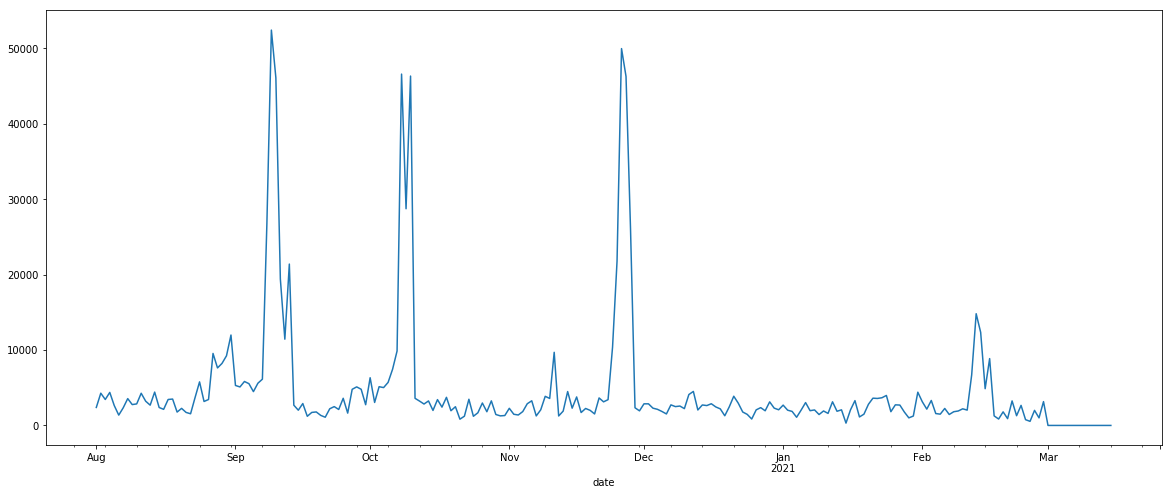

In [22]:
#Time series view
plt.figure(figsize=(20,8))
df.groupby(['date'])['revenue'].sum().plot(kind='line')
plt.show()

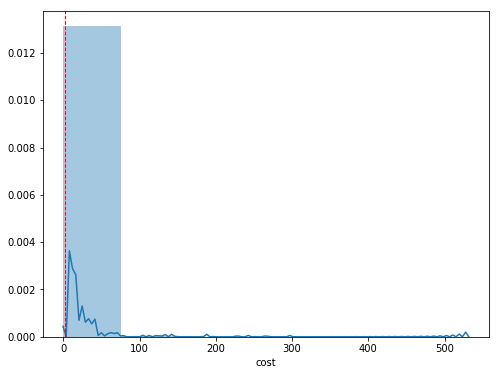

In [23]:
plt.figure(figsize=(8,6))
#plt.hist(df.cost,bins=7,density=True)
sns.distplot(df.cost,bins=7)
plt.axvline(df.cost.mean(), color='r', linestyle='dashed', linewidth=1)

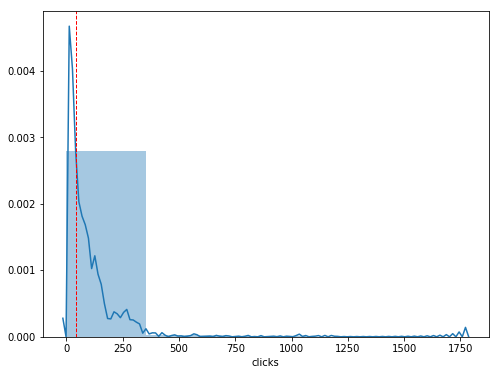

In [24]:
plt.figure(figsize=(8,6))
sns.distplot(df.clicks,bins=5)
plt.axvline(df.clicks.mean(), color='r', linestyle='dashed', linewidth=1)

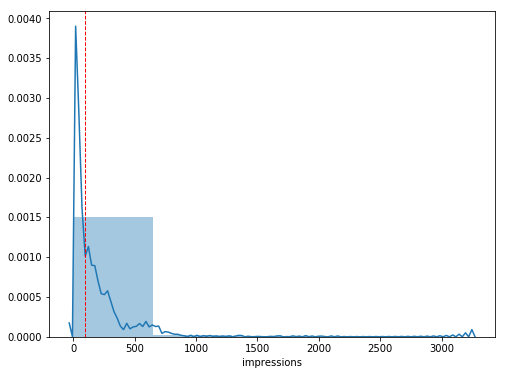

In [25]:
plt.figure(figsize=(8,6))
sns.distplot(df.impressions,bins=5)
plt.axvline(df.impressions.mean(), color='r', linestyle='dashed', linewidth=1)

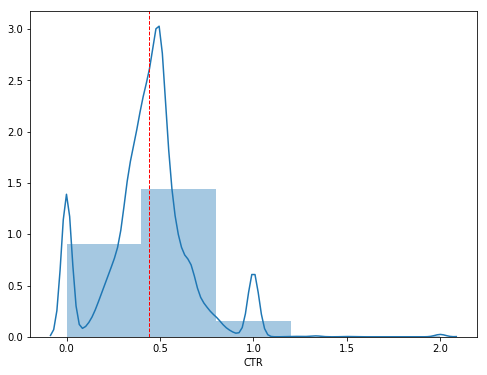

In [26]:
plt.figure(figsize=(8,6))
sns.distplot(df.CTR,bins=5)
plt.axvline(df.CTR.mean(), color='r', linestyle='dashed', linewidth=1)

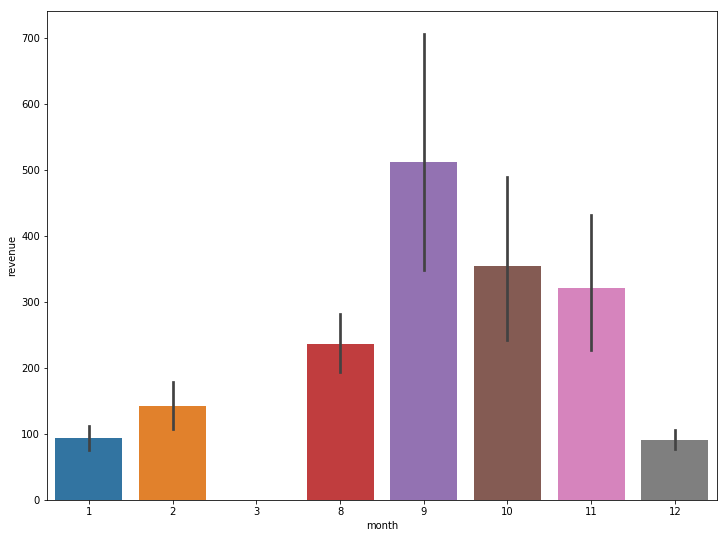

In [27]:

f, ax = plt.subplots(figsize=(12, 9));
sns.barplot('month','revenue',data=df)

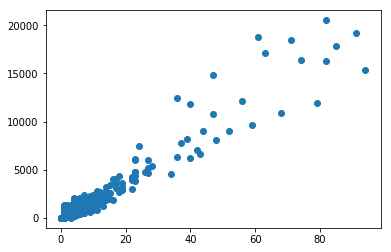

In [28]:
plt.scatter(df.conversions,df.revenue)
plt.show()

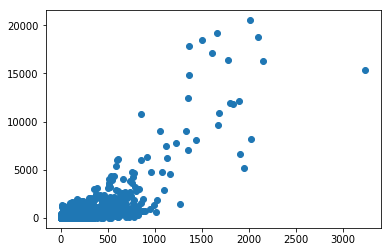

In [29]:
plt.scatter(df.impressions,df.revenue)
plt.show()

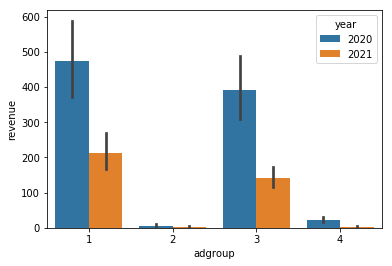

In [30]:
sns.barplot('adgroup','revenue',data=df,hue='year')

In [31]:
df.groupby(['date','adgroup'])['revenue'].sum().sort_values(ascending=False)

date        adgroup
2020-10-10  3          31765.46
2020-11-26  1          29398.31
2020-09-09  3          26956.77
2020-11-27  1          25685.71
2020-09-09  1          24911.10
2020-10-08  1          24712.36
2020-09-10  3          22992.52
            1          22842.76
2020-10-08  3          21387.56
2020-11-26  3          19936.61
2020-11-27  3          19772.93
2020-10-09  3          18998.57
2020-09-08  3          14645.04
2020-11-28  3          14397.45
2020-10-10  1          13699.55
2020-11-25  1          13215.34
2020-09-08  1          12130.20
2020-11-28  1          11718.86
2020-09-11  1          10931.86
2020-09-13  3          10899.66
            1          10162.72
2020-10-09  1           8863.47
2021-02-13  1           8610.92
2021-02-14  1           8579.21
2020-11-25  3           8302.65
2020-09-11  3           7124.64
2020-10-07  3           6520.10
2020-09-12  1           6255.83
2020-11-24  1           6196.04
2020-08-31  1           6170.63
                    

In [32]:
list(df.select_dtypes(exclude = ['object','datetime']).drop(columns=['revenue','tst']).columns)

['ad',
 'adgroup',
 'campaign',
 'clicks',
 'conversions',
 'cost',
 'impressions',
 'day',
 'month',
 'year',
 'CPC',
 'CTR',
 'COA']

In [33]:
df_copy=df.copy()


## Feature Trnsformation and Scaling

In [34]:
str_col=['ad','adgroup','campaign','year','month','day','date']
le=LabelEncoder()
for col in str_col:
    df[col]=le.fit_transform(df[col].values)

In [35]:
df.head()

,ad,adgroup,campaign,clicks,conversions,cost,date,impressions,revenue,tst,day,month,year,CPC,CTR,COA
date,,,,,,,,,,,,,,,,
2020-08-01,0,0,0,6,0,0.08,0,24,0.00,0,0,3,0,0.013333,0.250000,0.0000
2020-08-01,0,1,0,0,0,0.00,0,1,0.00,0,0,3,0,0.000000,0.000000,0.0000
2020-08-01,0,2,0,4,0,0.04,0,13,0.00,0,0,3,0,0.010000,0.307692,0.0000
2020-08-01,0,3,0,4,0,0.08,0,5,0.00,0,0,3,0,0.020000,0.800000,0.0000
2020-08-01,1,0,0,126,4,1.29,0,247,925.71,0,0,3,0,0.010238,0.510121,0.3225


In [36]:
sc=MinMaxScaler()
num_col=list(df.select_dtypes(exclude = ['object']).drop(columns=['revenue','tst']).columns)
df_scaled=sc.fit_transform(df[num_col].values)

In [37]:
df_scaled=pd.DataFrame(df_scaled,columns=num_col,index=date_ind)
df_scaled.head()

,ad,adgroup,campaign,clicks,conversions,cost,date,impressions,day,month,year,CPC,CTR,COA
date,,,,,,,,,,,,,,
2020-08-01,0.000000,0.000000,0.0,0.003388,0.000000,0.000151,0.0,0.007103,0.0,0.428571,0.0,0.003500,0.125000,0.000000
2020-08-01,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.428571,0.0,0.000000,0.000000,0.000000
2020-08-01,0.000000,0.666667,0.0,0.002259,0.000000,0.000075,0.0,0.003706,0.0,0.428571,0.0,0.002625,0.153846,0.000000
2020-08-01,0.000000,1.000000,0.0,0.002259,0.000000,0.000151,0.0,0.001235,0.0,0.428571,0.0,0.005249,0.400000,0.000000
2020-08-01,0.013514,0.000000,0.0,0.071146,0.042553,0.002428,0.0,0.075973,0.0,0.428571,0.0,0.002687,0.255061,0.005614


In [38]:
df[num_col]=df_scaled

In [39]:
df.isna().sum()

ad               0
adgroup          0
campaign         0
clicks           0
conversions      0
cost             0
date             0
impressions      0
revenue        318
tst              0
day              0
month            0
year             0
CPC              0
CTR              0
COA              0
dtype: int64

In [40]:
train=df[df.tst==0]
test=df[df.tst==1]

In [41]:
test.shape

(318, 16)

In [42]:
train=train.drop(columns=['tst','campaign'],axis=1)

In [43]:
test=test.drop(columns=['tst','revenue','campaign'],axis=1)
test.head()

,ad,adgroup,clicks,conversions,cost,date,impressions,day,month,year,CPC,CTR,COA
date,,,,,,,,,,,,,
2021-03-01,0.000000,0.000000,0.027668,0.010638,0.001092,0.938053,0.037060,0.0,0.285714,1.0,0.003107,0.202479,0.010096
2021-03-01,0.000000,0.666667,0.006776,0.000000,0.000320,0.938053,0.006485,0.0,0.285714,1.0,0.003718,0.272727,0.000000
2021-03-01,0.000000,1.000000,0.001694,0.000000,0.000094,0.938053,0.001235,0.0,0.285714,1.0,0.004374,0.300000,0.000000
2021-03-01,0.000000,0.333333,0.000565,0.000000,0.000019,0.938053,0.000309,0.0,0.285714,1.0,0.002625,0.250000,0.000000
2021-03-01,0.013514,0.333333,0.000565,0.000000,0.000019,0.938053,0.000618,0.0,0.285714,1.0,0.002625,0.166667,0.000000


In [44]:
X=train.columns.drop('revenue')
y=train.revenue

## Feature Selection

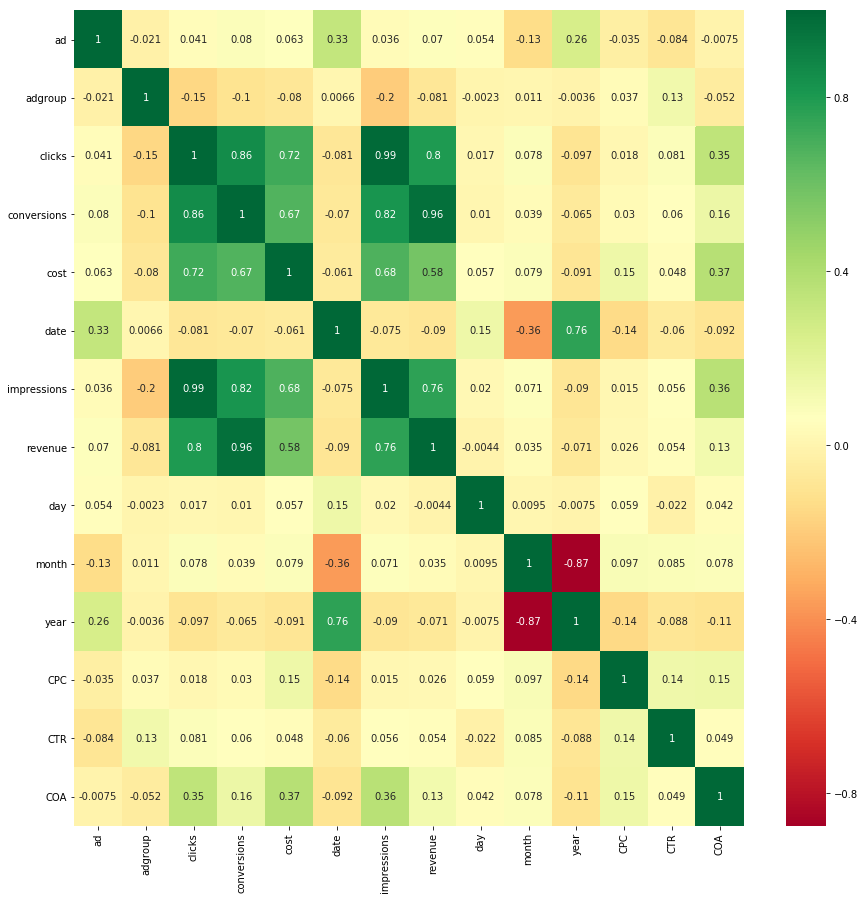

In [45]:
plt.figure(figsize=(15,15))
corrmat =train.corr()
top_corr_features = corrmat.index

#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#sns.heatmap(train.corr(),annot=True)
plt.show()


In [46]:
train[X].var().sort_values(ascending=False)

year           0.212179
adgroup        0.133162
month          0.129766
day            0.085816
date           0.068990
ad             0.068193
CTR            0.013463
impressions    0.003752
clicks         0.003199
conversions    0.003088
CPC            0.001256
COA            0.001225
cost           0.000731
dtype: float64

In [47]:
#features=['COA','cost','conversions','adgroup','clicks','CPC']---v5.0
#features=['conversions','adgroup','date','clicks','year']---v11.0
features=['conversions','adgroup','cost']  # replaced impression->cost
X=train[features]
y=train.revenue

## Train Test Split

In [48]:
# Since the given data is time series,we will not split on random basis...splitting data contigously
row=3420
X_train=X[:row]
X_val=X[row:]
y_train=y[:row]
y_val=y[row:]

In [49]:
X_test=test[features]

In [50]:
X_train.shape,y_val.shape

((3420, 3), (1151,))

## Model Building and Evaluation

In [51]:
def score(model,test,name='default'):
    model.fit(X_train,y_train)
    ypred=model.predict(test)
    print(name)
    print('Accuracy of training set: ',round(model.score(X_train,y_train)*100,2))
    print('Accuracy of test set: ',round(model.score(test,y_val)*100,2))
    print('mean squared error: ',round(mean_squared_error(y_val,ypred)/100,2))
    print('mean absolute error: ',round(mean_absolute_error(y_val,ypred),2))
    print('r2_score: ',round(r2_score(y_val,ypred)*100,2))

## 1. Linear Regresion

In [52]:
le=LinearRegression()
score(le,X_val,name='Linear Regression')

Linear Regression
Accuracy of training set:  94.44
Accuracy of test set:  71.25
mean squared error:  433.48
mean absolute error:  96.21
r2_score:  71.25


In [53]:
le.fit(X_train,y_train)
ypred=le.predict(test[features])
preds=le.predict(X_val)

In [54]:
test['result']=ypred

In [55]:
test.head()

,ad,adgroup,clicks,conversions,cost,date,impressions,day,month,year,CPC,CTR,COA,result
date,,,,,,,,,,,,,,
2021-03-01,0.000000,0.000000,0.027668,0.010638,0.001092,0.938053,0.037060,0.0,0.285714,1.0,0.003107,0.202479,0.010096,167.220128
2021-03-01,0.000000,0.666667,0.006776,0.000000,0.000320,0.938053,0.006485,0.0,0.285714,1.0,0.003718,0.272727,0.000000,-26.052141
2021-03-01,0.000000,1.000000,0.001694,0.000000,0.000094,0.938053,0.001235,0.0,0.285714,1.0,0.004374,0.300000,0.000000,-11.090253
2021-03-01,0.000000,0.333333,0.000565,0.000000,0.000019,0.938053,0.000309,0.0,0.285714,1.0,0.002625,0.250000,0.000000,-38.054924
2021-03-01,0.013514,0.333333,0.000565,0.000000,0.000019,0.938053,0.000618,0.0,0.285714,1.0,0.002625,0.166667,0.000000,-38.054924


In [56]:
ypred_df=pd.DataFrame(ypred,columns=['revenue'])

In [57]:
ypred_df.head()

,revenue
0,167.220128
1,-26.052141
2,-11.090253
3,-38.054924
4,-38.054924


In [58]:
ypred_df[ypred_df.revenue<0]=0

In [59]:
ypred_df.shape

(318, 1)

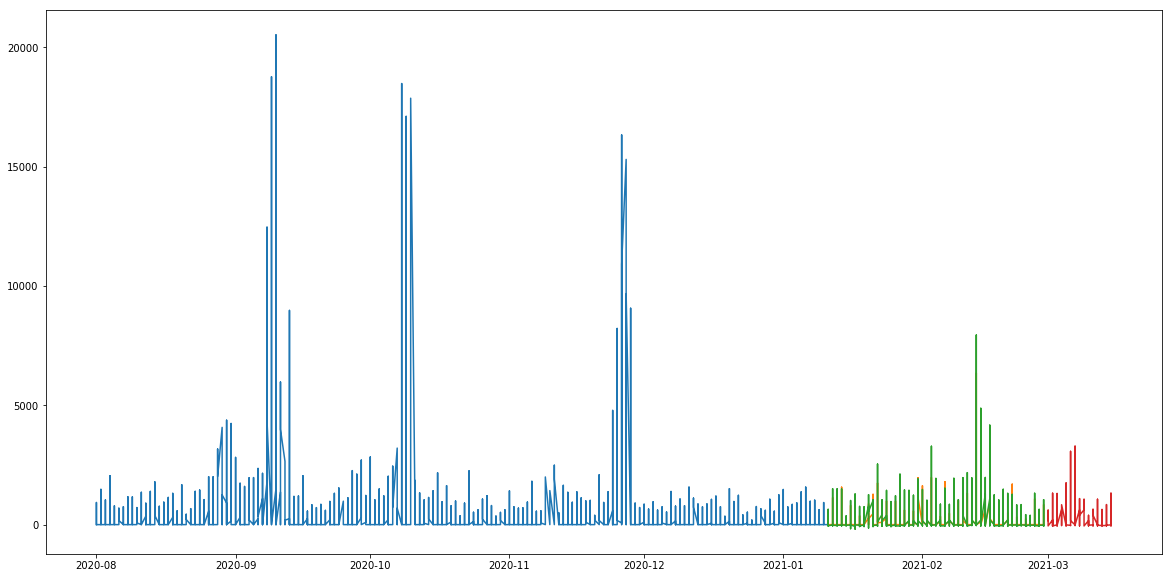

In [60]:
plt.figure(figsize=(20,10))
valid=train[row:]
valid['Predictions'] = 0
valid['Predictions'] = preds
train1=train[features][:row]
valid.index = train[features][row:].index
train1.index = train1[:row].index

plt.plot(train['revenue'][:row])
plt.plot(valid[['revenue', 'Predictions']])
plt.plot(test.result)
plt.show()

In [61]:
train[features][:row].shape

(3420, 3)

## 2. XGBoost Algorithm

In [62]:
# Best hyperparameters

xgb=XGBRegressor(n_estimators=37,learning_rate=0.05,booster='gbtree')
xgb.fit(X_train,y_train)

score(xgb,X_val,name='XG Boost')

XG Boost
Accuracy of training set:  94.18
Accuracy of test set:  91.29
mean squared error:  131.32
mean absolute error:  38.62
r2_score:  91.29


In [63]:
ypred=xgb.predict(X_test)
preds=xgb.predict(X_val)

In [64]:
ypred_df=pd.DataFrame(ypred,columns=['revenue'])

In [65]:
ypred_df.index=test.index
ypred_df.head(10)

,revenue
date,
2021-03-01,128.183533
2021-03-01,0.075007
2021-03-01,0.075007
2021-03-01,0.075007
2021-03-01,0.075007
2021-03-01,0.075007
2021-03-01,113.533897
2021-03-01,0.075007
2021-03-01,146.416107


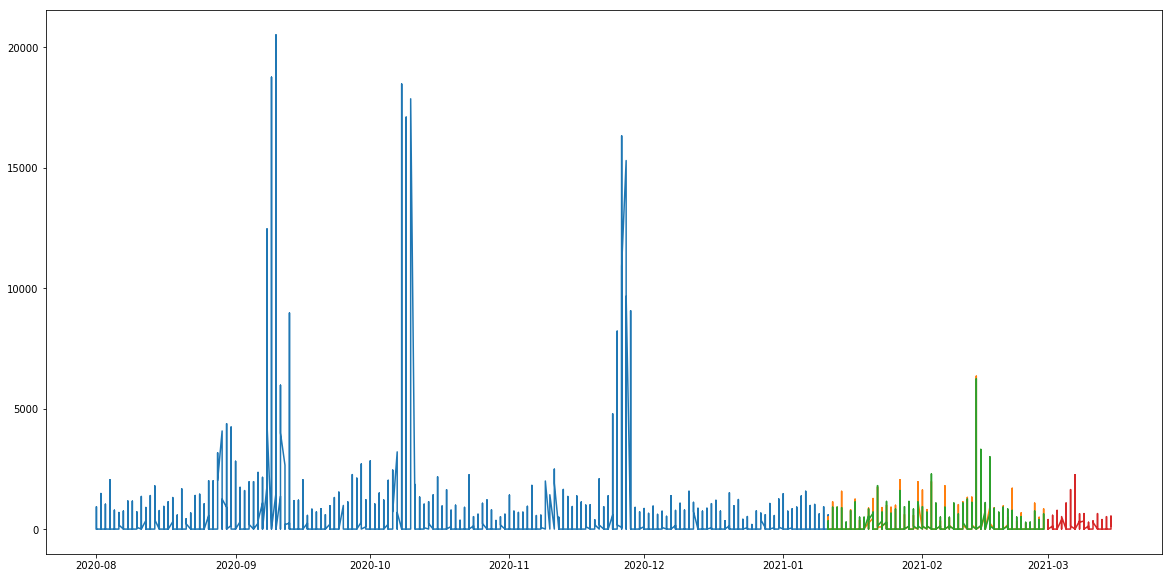

In [68]:
plt.figure(figsize=(20,10))
valid=train[row:]
valid['Predictions'] = 0
valid['Predictions'] = preds
train1=train[features][:row]
valid.index = train[features][row:].index
train1.index = train1[:row].index

plt.plot(train['revenue'][:row]) # train set
plt.plot(valid[['revenue', 'Predictions']]) # val set
plt.plot(ypred_df.revenue) # test set
plt.show()

In [69]:
ypred_df.to_csv('Submission14.csv',index=False)

In [74]:
#use this to find optimum value of n
mse=[]
mae=[]
for i in range(10,60):
    xgb=XGBRegressor(n_estimators=i,learning_rate=0.05)
    xgb.fit(X_train,y_train)
    pr=xgb.predict(X_val)
    ms=mean_squared_error(y_val,pr)
    ma=mean_absolute_error(y_val,pr)
    mse.append(ms)
    mae.append(ma)

In [75]:
10+mae.index(min(mae))

34

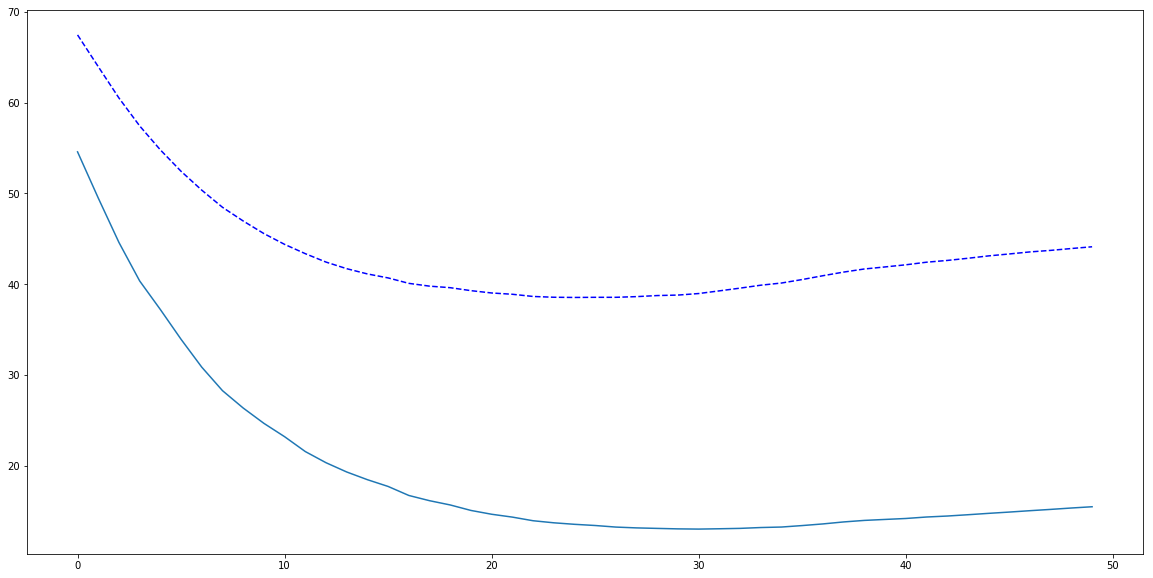

In [76]:
plt.figure(figsize=(20,10))
plt.plot(np.array(mae),'b--')
plt.plot(np.array(mse)/1000)
plt.show()

In [ ]:
# xgb_model = XGBRegressor(
#         objective = 'reg:squarederror',
#         colsample_bytree = 0.7,
#         learning_rate = 0.1,
#         max_depth = 3,
#         min_child_weight = 3,
#         n_estimators = 60,
#         subsample = 0.7)

# %time xgb_model.fit(X_train, y_train, early_stopping_rounds=7, eval_set=[(X_val, y_val)], verbose=False)

# y_pred_xgb = xgb_model.predict(X_val)

# mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

# print("MAE: ", mae_xgb)
# score(xgb_model,X_val,name='XG Boost')

In [ ]:
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.1,0.05],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [40, 50, 60],
#         'objective': ['reg:squarederror']
#     }

#     xgb_model = XGBRegressor()

#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            #scoring = 'neg_mean_absolute_error', #MAE
#                            #scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)

#     return gsearch.best_params_
# print(hyperParameterTuning(X_train, y_train))

In [77]:
from sklearn.linear_model import Lasso,Ridge

In [78]:
la=Ridge()
la.fit(X_train,y_train)
ypredla=la.predict(test[features])

In [79]:
score(la,X_val,name='Ridge Regression')

Ridge Regression
Accuracy of training set:  93.34
Accuracy of test set:  82.96
mean squared error:  256.84
mean absolute error:  69.25
r2_score:  82.96


## 3. Random Forest Regressor

In [80]:

rf=RandomForestRegressor(n_estimators=25,max_depth=5)

rf.fit(X_train,y_train)
ypredrf=rf.predict(test[features])

score(rf,X_val,name='Random Forest')

Random Forest
Accuracy of training set:  97.79
Accuracy of test set:  76.9
mean squared error:  348.24
mean absolute error:  50.17
r2_score:  76.9


In [81]:
ypred_df=pd.DataFrame(ypredrf,columns=['revenue'])
ypred_df.head(10)

,revenue
0,162.527623
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,160.575858
7,0.000000
8,164.110956
9,0.000000


In [ ]:
ypred_df.to_csv('Submission12.csv',index=False)